# CoCoRaHS AI - Intro to Topic Modeling

The goal here is to do exploratory data analysis (EDA) on the observation notes data available in the CoCoRaHS data source. For this analysis we looked at the DailyPrecipReport that has around **46.5 million** records, out of which around **8 million** records have observation notes. This study takes a random 1% sample from the 8 million records (**91,937** records with notes) to perform the initial EDA. 

Since we are dealing with large amount of unstructured and unlabeled data, the EDA is going to leverage two key unsupervised machine learning algorithms that are suitable for text analysis. Specifically, we will be looking at two topic modeling algorithms: **Latent Dirichlet Allocation (LDA)** and **K-Means Clustering**. 

This notebook is divided into the following sections:

- Setup – load and review the data from notes
- Breakdown of weather terms in the notes
- Topic Modeling with LDA
- Topic Modeling with K-Means Clustering
- Compare predictions from LDA and K-Means on test data

## Setup

**Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import timeit
from IPython.display import display, HTML, Image
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
print("pandas version: {}\nnumpy version: {}\nsklearn version: {}\nnlkt version: {}".format(pd.__version__, 
                                                                                            np.__version__, 
                                                                                            sklearn.__version__, 
                                                                                            nltk.__version__))

pandas version: 0.23.4
numpy version: 1.16.2
sklearn version: 0.20.3
nlkt version: 3.3


**Load the sample 1% data with observation notes from DailyPrecipReport table**

Note that data was sampled in SQL and the correspoing csv file was saved in Azure blob storage. Here is SQL that was used to sample the data.

``` mysql
select [Notes] from [dbo].[DailyPrecipReport] where [DailyPrecipReportID] in 
(
    select top 1 percent [DailyPrecipReportID] 
    from [dbo].[DailyPrecipReport] 
    WHERE 
    [Notes] IS NOT NULL
    AND
    TRIM([Notes])  <> ''
    order by newid()
)
```

In [2]:
data_url = ('https://cocorahsai.blob.core.windows.net/notes/percent_1.csv')
df = pd.read_csv(data_url, names=['notes'], sep=u'\0091')
df['notes'] = df['notes'].astype('str')
print(len(df))

91937


Helper method to display dataframes

In [4]:
def display_dataframe(df_in):
    s = df_in.style.set_properties(**{'text-align': 'left'})
    s.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    display(HTML(s.render()))

In [4]:
# print the first 10 rows
display_dataframe(df.head(10))

,notes
0,Very intense lightning from approx. 8:30 to 10:00
1,"Total snow = 0, new snow = 0"
2,Rain yesterday AM --snow in parts of town
3,"5/8 @ 12:35am 0.02""5/8 @ 4:15pm 0.11""5/8 @ 7:30pm 0.10""5/9 @ 7:00am 0.01"""
4,bulk data:
5,"HAIL MIXED WITH RAIN FROM 12:45 TO 1 P.M. ON JULY 1. DIAMETER ~3/8 INCH. HAIL PAD TURNED IN OUTSIDE YOUR OFFICE EARLY THIS MORNING (7/3). I WILL BE OUT OF TOWN FROM 7/6 UNTIL 7/23 AND UNABLE TO MAKE PRECIPITATION REPORTS. ALSO, PLEASE SEE WHAT YOU CAN DO WITH YOUR EMAIL SYSTEM. I HAVE RECEIVED AT LEAST A DOZEN EMAILS FROM PEOPLE WHO RECEIVED ERRONEOUS EMAIL TELLING YOU TO REMOVE THEM FROM YOUR LIST. THAT IS MORE ANNOYING THAT GETTING A SINGLE ERRONEOUS MESSAGE! (I KNOW WHY IT IS HAPPENING, I READ THAT EMAIL, TOO. PERHAPS CHANGE YOUR INTERNAL ADDRESS?) REGARDS, GEORGEANN"
6,bulk data:
7,"snow was falling at 7am 1/16/01 and continued until some time during night of 1/17/01.1/16/01 1:00pm total 4.6"" snow 1.3"" new snow1/16/01 1:00pm total 0.28"" moisture 0.06"" new moisture1/16/01 6:30pm total 5.0"" snow 0.4"" new snow1/16/01 6:30pm total 0.3"" moisture 0.02"" new moisture"
8,Total percipitaion was a combination of rain and snow.
9,Data from city automatic station.


The data shows both very short and very long notes. Let's look at the stats on the length (word counts) of the notes.

In [3]:
notes_len = df.notes.map(lambda x: len(x.split()))
notes_len.describe()

count    91937.000000
mean     10.632999   
std      13.043876   
min      1.000000    
25%      4.000000    
50%      7.000000    
75%      11.000000   
max      330.000000  
Name: notes, dtype: float64

## Breakdown of Weather Terms

We start with defining a list of weather events of interested. Then we will look at the break down of the these weather events or terms as mentioned in the notes.

In [6]:
# Create weather events dictionary
weather_events = []
weather_events.append('rain')
weather_events.append('snow')
weather_events.append('precipitation')
weather_events.append('wind')
weather_events.append('fog')
weather_events.append('hail')
weather_events.append('sun')
weather_events.append('cloud')
weather_events.append('thunder')
weather_events.append('lightning')
weather_events.append('warm')
weather_events.append('hot')
weather_events.append('cold')
weather_events.append('freeze')
weather_events.append('arid')
weather_events.append('humid')
weather_events.append('thunderstorms')
weather_events.append('downbursts')
weather_events.append('tornadoes')
weather_events.append('cyclones')
weather_events.append('waterspouts')
weather_events.append('flood')
weather_events.append('blizzards')
weather_events.append('snowstorms')
weather_events.append('ice storms')
weather_events.append('dust storms')

In [7]:
# Make a copy of the originial dataframe
df_2 = df.copy()
df_2['notes'] = df_2['notes'].astype('str')

# Search of the weather events or terms in the notes
evt_counts = []
for evt in weather_events:
    df_2[evt] = df_2['notes'].apply(lambda x: 1 if (evt in x) else 0)
    count = len(df_2.where(df_2[evt] == 1).dropna())
    percent = round(count/len(df_2) * 100, 1)
    evt_counts.append((evt, count, percent))

# Create a new weather events dataframe
evt_df = pd.DataFrame(evt_counts, columns=['Event', 'Count', 'Percent'])
evt_df.sort_values(by=['Count'], ascending=False, inplace=True)

display_dataframe(evt_df)

,Event,Count,Percent
0,rain,11744,12.8
3,wind,9239,10
7,cloud,8646,9.4
1,snow,7220,7.9
6,sun,3895,4.2
4,fog,2469,2.7
15,humid,2263,2.5
8,thunder,1850,2
10,warm,1293,1.4
12,cold,1274,1.4


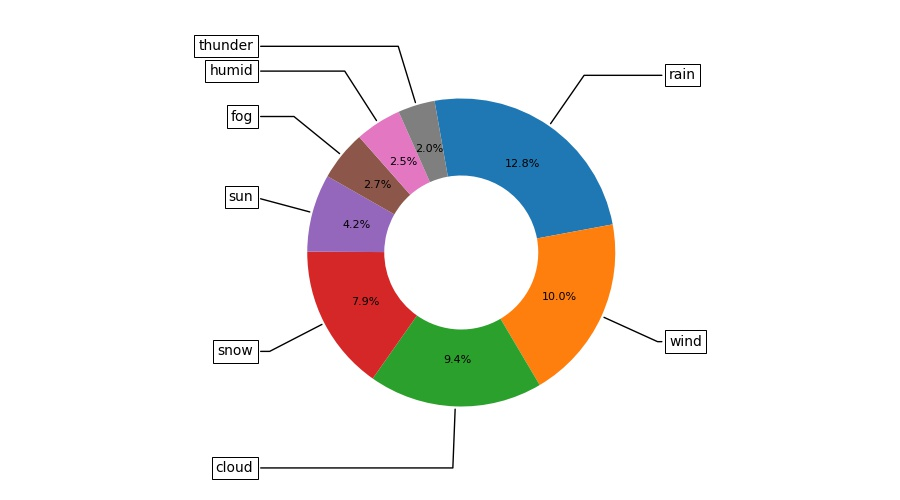

In [32]:
display(HTML('<h1>Breakdown of Top Weather Terms (>= 2%)</h1>'))
display(Image(filename='./images/w_dist.jpg'))

## Topic Modeling with LDA

**What is topic modeling?**

- It is a high-level analysis of what's in a text collection
- Topic is a theme or subject of the discussion
- Topics are represented as word distributions
- A single document can be a mixture of multiple topics


**What is LDA?**

LDA is a generative probabilistic model for a collection of text corpora (large and structured set of texts). In LDA, each item (or word) of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in turn modeled as an infinite mixture over an underlying set of topic probabilities. Words are generated by topics (by fixed conditional distribution) and topics are infinitely exchangeable within a document.


**Practical implications of LDA**

- How many topics?
  - Finding or even guessing the number of topics is hard
- Interpreting topics
  - Topics are just word distributions
- Making sense of words / generating labels is subjective

**Data Cleaning**

Remove autogenerated notes that does not have qualitative weather information

In [4]:
# define list of autogenerated notes
words = ['MSWS data', 'Data from city automatic station', 'bulk data', 'LRM Estimates',
        'Observer for iOS', 'Observer for Android']

# remove documents with autogenerated notes
df_3 = df[~np.logical_or.reduce([df['notes'].str.contains(word, case = False) for word in words])]

print("review impact of removing autogenerated notes")
print('original size: {} new size: {} difference: {}'.format(len(df), len(df_3), len(df) - len(df_3)))
print()

print("stats on the length (word counts) of the notes")
notes_len = df_3.notes.map(lambda x: len(x.split()))
notes_len.describe()

review impact of removing autogenerated notes
original size: 91937 new size: 71636 difference: 20301

stats on the length (word counts) of the notes


count    71636.000000
mean     11.662000   
std      14.572451   
min      1.000000    
25%      4.000000    
50%      7.000000    
75%      14.000000   
max      330.000000  
Name: notes, dtype: float64

### Generate Corpus

Generate a vocabulary or collection of words that will be used in topic modeling. As a standard practice, we will filter out all stop words in English (for e.g. words like THE, THIS, BUT etc). The two other key parameters are `min_df`, and `max_df`. In this case, we have chosen **min_df = 100**, that means we will consider only those words that appear in atleast 100 different documents or notes. We have chosen **max_df = 20%**, that means we will ignore words that appear in more that 20% of the documents or notes. Note that the most frequent word **rain** was present in **11,744** documents, that is around **16%** of the new document count of **71,636**, thus we have set `max_df` to be at 20%.

In [6]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=100, max_df=0.2, stop_words='english', 
                       token_pattern='\\b[a-zA-Z][a-zA-Z][a-zA-Z]+\\b')
X = vect.fit_transform(df_3.notes.values)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

print('vocabulary size: {}'.format(len(vect.vocabulary_.items())))

vocabulary size: 487


### Generate the LDA model

For the current iteration we have kept the number of topics to 5 and this will also simplify interpretability and label generation. In the future, we should experiment to find optimal number of topics for the current corpus that balances granularity and interpretability, and thus making it both practical and useable.

In [8]:
num_topics = 5
print('starting...')
start_time = timeit.default_timer()
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id_map, passes=25, 
                                          random_state=31)
time_elapsed = timeit.default_timer() - start_time
print('done')
print('Total time (min): ', int(round(time_elapsed/60.0, 0)))

starting...
done
Total time:  1780.7557672999992


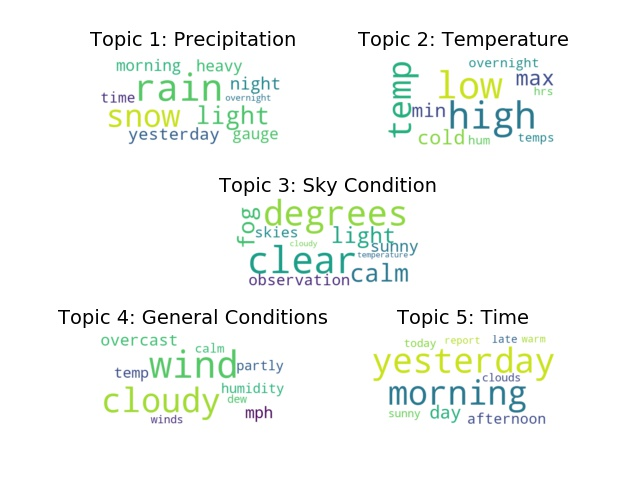

In [33]:
display(HTML('<h1>Review Generated Topics</h1>'))
display(Image(filename='./images/word_cloud.jpg'))

In [10]:
cols = [np.hstack((['Topic 1: Precipitation'] * 2, ['Topic 2: Temperature'] * 2, 
                  ['Topic 3: Sky Condition'] * 2, ['Topic 4: General Conditions'] * 2, ['Topic 5: Time'] * 2)), 
        ['Word', 'Probability'] * 5]

topics = np.hstack((ldamodel.show_topic(0), ldamodel.show_topic(1), ldamodel.show_topic(2), 
                   ldamodel.show_topic(3), ldamodel.show_topic(4)))

results = pd.DataFrame(topics, index=[i+1 for i in range(10)], columns = cols)

results

Topic 1: Precipitation              Topic 2: Temperature               \
                     Word  Probability                 Word  Probability   
1   rain                   0.13192254   low                  0.16864789    
2   snow                   0.08914039   high                 0.16782343    
3   light                  0.052694164  temp                 0.12963904    
4   night                  0.02159634   max                  0.03874604    
5   yesterday              0.020422893  cold                 0.033713      
6   morning                0.017637948  min                  0.031328786   
7   heavy                  0.017087666  overnight            0.026137233   
8   gauge                  0.016844075  hum                  0.021798356   
9   time                   0.014026402  temps                0.021480812   
10  overnight              0.013509317  hrs                  0.01765215    

   Topic 3: Sky Condition              Topic 4: General Conditions  \
                     Word  Probability                        Word   
1   clear                  0.15041752   wind                         
2   degrees                0.12995939   cloudy                       
3   calm                   0.054021996  overcast                     
4   fog                    0.047735058  mph                          
5   light                  0.045691185  temp                         
6   sunny                  0.038453642  partly                       
7   observation            0.035874773  humidity                     
8   skies                  0.034137305  calm                         
9   temperature            0.033032294  dew                          
10  cloudy                 0.031644195  winds                        

                Topic 5: Time               
    Probability          Word  Probability  
1   0.12169041   yesterday     0.056874104  
2   0.09725117   morning       0.054393545  
3   0.05790704   day           0.05290796   
4   0.055929784  afternoon     0.044997264  
5   0.04825205   today         0.02557047   
6   0.039639954  clouds        0.025155317  
7   0.038587525  sunny         0.024591105  
8   0.033293527  late          0.022528084  
9   0.027130969  report        0.01881532   
10  0.026217835  warm          0.018715065

### Topic Distribution

In LDA, each document may be viewed as a mixture of various topics where each document is considered to have a set of topics that are assigned to it via LDA. To get an idea of topic distribution across the entire corpus, we will assign each document to a topic based on the topic probability for that document – we will pick the topic with highest probability for that document.

In [11]:
topic_names = ['Topic 1: Precipitation', 'Topic 2: Temperature', 'Topic 3: Sky Condition', 
             'Topic 4: General Conditions', 'Topic 5: Time']

document_topics = ldamodel.get_document_topics(corpus)
doc_topic_list = []
doc_topic_prob_list = []
for doc_topic in document_topics:
    t_group, t_group_prob = (max(doc_topic, key=lambda item:item[1]))
    doc_topic_list.append(t_group)
    doc_topic_prob_list.append(t_group_prob)

_, counts = np.unique(doc_topic_list, return_counts=True)
topic_dist = []
for i in range(len(counts)):
    topic_dist.append((i+1, topic_names[i], counts[i], round(counts[i]/len(document_topics) * 100, 1)))

topic_dist_pd = pd.DataFrame(topic_dist, columns=['Topic #', 'Topic Name', 'Counts', 'Percent'])
display_dataframe(topic_dist_pd)

,Topic #,Topic Name,Counts,Percent
0,1,Topic 1: Precipitation,25148,35.1
1,2,Topic 2: Temperature,9107,12.7
2,3,Topic 3: Sky Condition,13562,18.9
3,4,Topic 4: General Conditions,14317,20
4,5,Topic 5: Time,9502,13.3


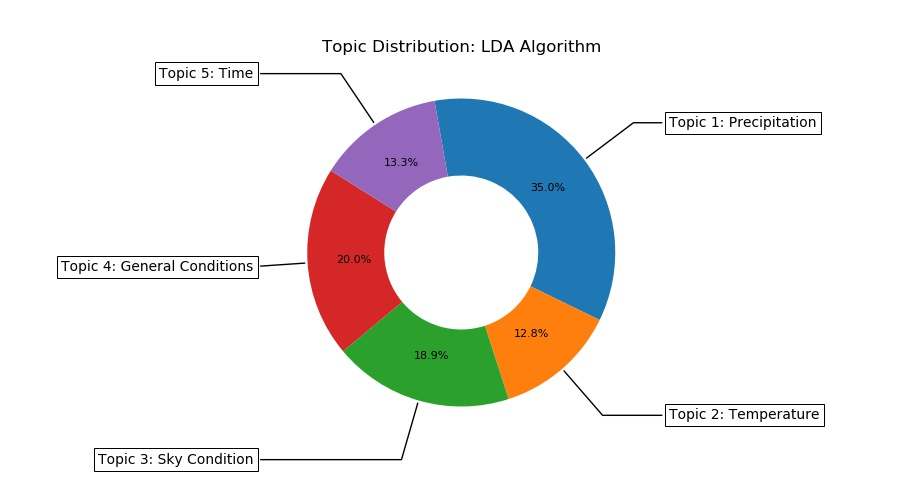

In [34]:
display(Image(filename='./images/td_lda.jpg'))

## Topic Modeling with K-Means Clustering

**What is K-Means Clustering?**

K-Means Clustering is a discriminative, unsupervised cluster analysis algorithm that aims to partition n observations (documents) into k disjoint clusters (topics). For a given number of clusters, the goal of the algorithm is to minimize the square distance between an observation and the assigned cluster centroid by varying both the assigned cluster and the cluster centroid. Unlike LDA where each observation can belong to multiple clusters, K-Means is considered hard clustering as each observation is assigned to one and only one cluster.

### Generate the Clusters / Topics

We will use the same hyperparameters as the LDA model: **min_df: 100**, **max_df: 0.2**, and **number of topics: 5**

In [12]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
 
 
def process_text(text, stem=True):
    text = text.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens

vectorizer = TfidfVectorizer(tokenizer=process_text,
                             stop_words=stopwords.words('english'),
                             max_df=0.2,
                             min_df=100,
                             lowercase=True)

tfidf_model = vectorizer.fit_transform(df_3.notes.values)

n_clusters = 5
km_model = KMeans(n_clusters=n_clusters, random_state=95)

print('starting...')
start_time = timeit.default_timer()
km_model.fit(tfidf_model)
time_elapsed = timeit.default_timer() - start_time
print('done')
print('Total time (min): ', int(round(time_elapsed/60.0, 0)))

starting...
done
Total time:  481.85879639999985


### Review Generated Topics

K-Means assigns each document to a cluster. In order to interpret each cluster and assign labels, we will look at sample documents in the cluster to make the qualitative determination.

In [13]:
clusters = ['Topic 1: General', 'Topic 2: Cloudy', 'Topic 3: Temperature', 
            'Topic 4: Precipitation', 'Topic 5: Sky Condition']

clusters = ['Topic 1: Precipitation', 'Topic 2: Temperature', 'Topic 3: General', 
            'Topic 4: Sky Condition', 'Topic 5: Cloudy']

# assign the predicted cluster for each document / note in the data frame
df_3['pred'] = km_model.labels_

topic_dist = []
for i in range(n_clusters):
    print('Topic #: {} Desc: {}'.format(i+1, clusters[i]))
    cdf = df_3[df_3.pred == i].notes
    topic_dist.append((i+1, clusters[i], len(cdf), round(len(cdf)*100.0/len(df_3), 1)))
    print(cdf.head(5))
    print()

Topic #: 1 Desc: Topic 1: Precipitation
1     Total snow = 0, new snow = 0                                                                                                                                                                                                                                                             
2     Rain yesterday AM  --snow in parts of town                                                                                                                                                                                                                                               
7     snow was falling at 7am 1/16/01 and continued until some time during night of 1/17/01.1/16/01 1:00pm total 4.6" snow 1.3" new snow1/16/01 1:00pm total 0.28" moisture 0.06" new moisture1/16/01 6:30pm total 5.0" snow 0.4" new snow1/16/01 6:30pm total 0.3" moisture 0.02" new moisture
8     Total percipitaion was a combination of rain and snow.                                    

### Topic Distribution

Since K-Means assigns each document to a cluster, we can very easily determine the overall cluster distribution for the corpus.

In [14]:
topic_dist_km_pd = pd.DataFrame(topic_dist, columns=['Topic #', 'Topic Name', 'Counts', 'Percent'])
display_dataframe(topic_dist_km_pd)

,Topic #,Topic Name,Counts,Percent
0,1,Topic 1: Precipitation,6694,9.3
1,2,Topic 2: Temperature,8632,12
2,3,Topic 3: General,44589,62.2
3,4,Topic 4: Sky Condition,6127,8.6
4,5,Topic 5: Cloudy,5594,7.8


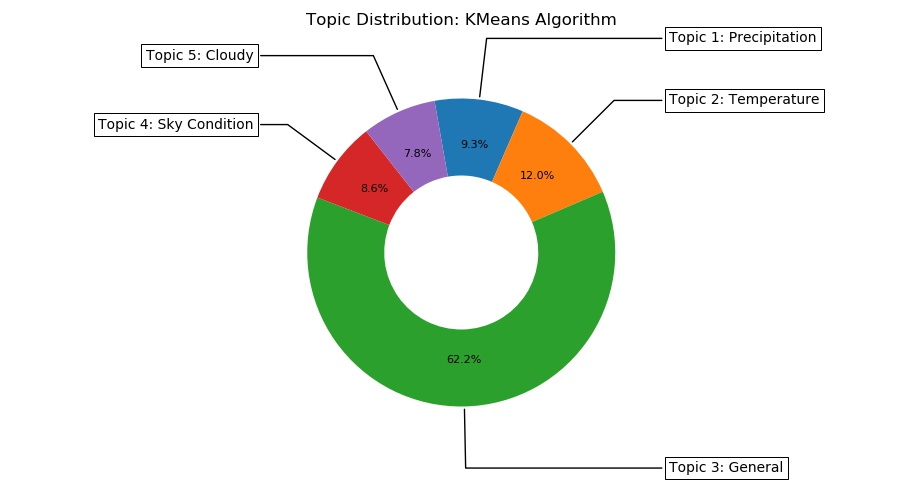

In [35]:
display(Image(filename='./images/td_kmeans.jpg'))

## Compare predictions from LDA and K-Means on test data

Both the LDA and K-Means model are used to automatically tag new incoming text data by using the topics learned. In this section, we will apply the learned models to previously unseen data (test data) to assign the new documents to their respective topics.

### Load and review test data

In [16]:
test_data_url = ('https://cocorahsai.blob.core.windows.net/notes/test/test_data.csv')
df_test = pd.read_csv(test_data_url, names=['notes'])
df_test['notes'] = df_test['notes'].astype('str')
display_dataframe(df_test)

,notes
0,It started raining about 8:45 in the morning and kept raining steadily. By 4:00 in the afternoon .61 of rain had fallen.
1,Current Conditions @ 0700: 32.5° Calm and clear to the west and partly cloudy to the east.
2,overnight low 28F
3,"Another day of heavy rain. Storm total of 2.50"""
4,"Clear, 79.3°; BP 30.10, rising."
5,there was hail with this storm. Very strong winds so don't know if all precip went in the guage.
6,frost and fog
7,"Overcast, 33."
8,"Current temp is 36F with light rain falling from cloudy skies and NW winds at 14 gusting to 26 mph. Yesterday's high temp was 66F (3 degrees short of the record of 69F) at 5:48 p.m. Light rain showers and drizzle fell off and on during the morning hours with light to moderate SE winds. By afternoon the showers ended and the winds shifted to light S with overcast skies. During the evening hours light SE winds prevailed with cloudy skies. Overnight, light rain showers began again with moderate NW winds gusting up to 26 mph. Temps dropped sharply during the night from the high 50s down to the mid 30s."
9,"Currently mostly cloudy, 30F."


### Assign Primary Topic to the test data using the LDA Model

In [17]:
X_test = vect.transform(df_test.notes.values)
test_corpus = gensim.matutils.Sparse2Corpus(X_test, documents_columns=False)
test_results = ldamodel[test_corpus]

topic_list = []
topic_prob_list = []
for test_topic in test_results:
    t_group, t_group_prob = (max(test_topic, key=lambda item:item[1]))
    topic_list.append(topic_names[t_group])
    topic_prob_list.append(t_group_prob)

df_test['Primary Topic'] = topic_list
df_test['Probability'] = topic_prob_list

display_dataframe(df_test)

,notes,Primary Topic,Probability
0,It started raining about 8:45 in the morning and kept raining steadily. By 4:00 in the afternoon .61 of rain had fallen.,Topic 1: Precipitation,0.674702
1,Current Conditions @ 0700: 32.5° Calm and clear to the west and partly cloudy to the east.,Topic 4: General Conditions,0.772588
2,overnight low 28F,Topic 2: Temperature,0.732459
3,"Another day of heavy rain. Storm total of 2.50""",Topic 1: Precipitation,0.865289
4,"Clear, 79.3°; BP 30.10, rising.",Topic 3: Sky Condition,0.400005
5,there was hail with this storm. Very strong winds so don't know if all precip went in the guage.,Topic 1: Precipitation,0.741541
6,frost and fog,Topic 3: Sky Condition,0.733332
7,"Overcast, 33.",Topic 4: General Conditions,0.599999
8,"Current temp is 36F with light rain falling from cloudy skies and NW winds at 14 gusting to 26 mph. Yesterday's high temp was 66F (3 degrees short of the record of 69F) at 5:48 p.m. Light rain showers and drizzle fell off and on during the morning hours with light to moderate SE winds. By afternoon the showers ended and the winds shifted to light S with overcast skies. During the evening hours light SE winds prevailed with cloudy skies. Overnight, light rain showers began again with moderate NW winds gusting up to 26 mph. Temps dropped sharply during the night from the high 50s down to the mid 30s.",Topic 1: Precipitation,0.442195
9,"Currently mostly cloudy, 30F.",Topic 4: General Conditions,0.732839


### Predict Topic using the K-Means Model

In [18]:
pred = km_model.predict(vectorizer.transform(df_test.notes.values))
df_test['K-Means Topic'] = [clusters[i] for i in pred]

display_dataframe(df_test)

,notes,Primary Topic,Probability,K-Means Topic
0,It started raining about 8:45 in the morning and kept raining steadily. By 4:00 in the afternoon .61 of rain had fallen.,Topic 1: Precipitation,0.674702,Topic 3: General
1,Current Conditions @ 0700: 32.5° Calm and clear to the west and partly cloudy to the east.,Topic 4: General Conditions,0.772588,Topic 5: Cloudy
2,overnight low 28F,Topic 2: Temperature,0.732459,Topic 2: Temperature
3,"Another day of heavy rain. Storm total of 2.50""",Topic 1: Precipitation,0.865289,Topic 3: General
4,"Clear, 79.3°; BP 30.10, rising.",Topic 3: Sky Condition,0.400005,Topic 4: Sky Condition
5,there was hail with this storm. Very strong winds so don't know if all precip went in the guage.,Topic 1: Precipitation,0.741541,Topic 3: General
6,frost and fog,Topic 3: Sky Condition,0.733332,Topic 3: General
7,"Overcast, 33.",Topic 4: General Conditions,0.599999,Topic 3: General
8,"Current temp is 36F with light rain falling from cloudy skies and NW winds at 14 gusting to 26 mph. Yesterday's high temp was 66F (3 degrees short of the record of 69F) at 5:48 p.m. Light rain showers and drizzle fell off and on during the morning hours with light to moderate SE winds. By afternoon the showers ended and the winds shifted to light S with overcast skies. During the evening hours light SE winds prevailed with cloudy skies. Overnight, light rain showers began again with moderate NW winds gusting up to 26 mph. Temps dropped sharply during the night from the high 50s down to the mid 30s.",Topic 1: Precipitation,0.442195,Topic 3: General
9,"Currently mostly cloudy, 30F.",Topic 4: General Conditions,0.732839,Topic 5: Cloudy
